# LSTM Modelling 

In [2]:
import numpy as np
import pandas as pd
import random
from datetime import datetime
import matplotlib.pyplot as plt
from pprint import pprint

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

import warnings
warnings.filterwarnings("ignore")

2023-04-28 22:24:43.963651: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-28 22:24:44.221380: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-28 22:24:44.221425: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-28 22:24:45.024486: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## Data Refactor

In [3]:
training_data = pd.read_csv("./StationsDatasets/training.csv").drop(columns=["Unnamed: 0"])
testing_data = pd.read_csv("./StationsDatasets/testing.csv").drop(columns=["Unnamed: 0"])

training_data.head()

,Hour,StationEnd,Count,Day,Year,Count1,Count1week,Count2week,Count3week,Count4week
0,6,42,1,60,2011,0,9,1,0,0
1,6,9,1,60,2011,0,5,1,0,0
2,6,10,2,60,2011,0,6,0,2,0
3,6,5,2,60,2011,0,6,1,0,1
4,6,33,1,60,2011,0,5,0,1,1


In [4]:
trips = pd.read_csv("./CSVFiles/datatrips.csv").drop(columns=["Unnamed: 0"])

day = []
year = []
for trip in trips.values:
    date = datetime.strptime(trip[0], "%Y-%m-%d %H:%M:%S").timetuple()
    day.append(date.tm_yday)
    year.append(date.tm_year)

trips = trips.drop(columns=["DateEnd"])
trips["Day"] = day
trips["Year"] = year

trips.head()

,StationEnd,Count,Season,Year,Month,Hour,Holiday,Weekday,Workingday,WeatherSituation,Temp,ATemp,Humidity,Windspeed,Day
0,26,1,1,2011,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,1
1,17,1,1,2011,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,1
2,38,2,1,2011,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,1
3,27,2,1,2011,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,1
4,2,1,1,2011,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,1


In [5]:
new_data = pd.DataFrame({"Holiday": [], "Weekday": [], "Workingday": [], "WeatherSituation": [], "Temp": [], "ATemp": [], "Humidity": [], "Windspeed": []})

for data in training_data.values:
    hour = data[0]
    station = data[1]
    day = data[3]
    year = data[4]

    df = trips.loc[(trips["StationEnd"] == station) & (trips["Day"] == day) & (trips["Year"] == year) & (trips["Hour"] == hour)].values[0][6:-1]
    new_data.loc[len(new_data)] = df

training_data = training_data.join(new_data)
training_data.head()

,Hour,StationEnd,Count,Day,Year,Count1,Count1week,Count2week,Count3week,Count4week,Holiday,Weekday,Workingday,WeatherSituation,Temp,ATemp,Humidity,Windspeed
0,6,42,1,60,2011,0,9,1,0,0,0.0,2.0,1.0,1.0,0.2,0.1818,0.59,0.2985
1,6,9,1,60,2011,0,5,1,0,0,0.0,2.0,1.0,1.0,0.2,0.1818,0.59,0.2985
2,6,10,2,60,2011,0,6,0,2,0,0.0,2.0,1.0,1.0,0.2,0.1818,0.59,0.2985
3,6,5,2,60,2011,0,6,1,0,1,0.0,2.0,1.0,1.0,0.2,0.1818,0.59,0.2985
4,6,33,1,60,2011,0,5,0,1,1,0.0,2.0,1.0,1.0,0.2,0.1818,0.59,0.2985


In [6]:
new_data = pd.DataFrame({"Holiday": [], "Weekday": [], "Workingday": [], "WeatherSituation": [], "Temp": [], "ATemp": [], "Humidity": [], "Windspeed": []})

for data in testing_data.values:
    hour = data[0]
    station = data[1]
    day = data[3]
    year = data[4]

    df = trips.loc[(trips["StationEnd"] == station) & (trips["Day"] == day) & (trips["Year"] == year) & (trips["Hour"] == hour)].values[0][6:-1]
    new_data.loc[len(new_data)] = df

testing_data = testing_data.join(new_data)
testing_data.head()

,Hour,StationEnd,Count,Day,Year,Count1,Count1week,Count2week,Count3week,Count4week,Holiday,Weekday,Workingday,WeatherSituation,Temp,ATemp,Humidity,Windspeed
0,14,31,3,60,2011,3,6,5,4,0,0.0,2.0,1.0,1.0,0.32,0.3333,0.36,0.1343
1,14,2,7,60,2011,3,7,5,4,1,0.0,2.0,1.0,1.0,0.32,0.3333,0.36,0.1343
2,14,8,5,60,2011,4,11,2,7,1,0.0,2.0,1.0,1.0,0.32,0.3333,0.36,0.1343
3,14,30,1,60,2011,3,9,3,9,1,0.0,2.0,1.0,1.0,0.32,0.3333,0.36,0.1343
4,15,8,4,60,2011,5,9,3,6,1,0.0,2.0,1.0,1.0,0.34,0.3636,0.34,0.0000


## Correlation Features

In [7]:
def featureSelect_dataframe(X, y, criteria, k):

    # initialize our function/method
    reg = SelectKBest(criteria, k=k).fit(X,y)
    
    # transform after creating the reg (so we can use getsupport)
    X_transformed = reg.transform(X)

    # filter down X based on kept columns
    X = X[[val for i,val in enumerate(X.columns) if reg.get_support()[i]]]

    # return that dataframe
    return X, reg.scores_

X = training_data[[col for col in training_data.columns if "Count" not in col]]
y = training_data['Count']

new_x_data = []

# F-value between label/feature for regression tasks.
New_X, scoresX = featureSelect_dataframe(X, y, f_regression, 11)
new_x_data_1 = {list(X.columns)[x]:scoresX[x] for x in range(0,len(list(X.columns)))}
pprint(sorted(new_x_data_1.items(), key=lambda x:x[1], reverse=True))

[('Temp', 13959.053609657109),
 ('ATemp', 13652.393531704087),
 ('Humidity', 11828.77982599868),
 ('Hour', 9295.408663796747),
 ('Year', 6007.715702580816),
 ('StationEnd', 2944.0556696158733),
 ('WeatherSituation', 2535.6932122292387),
 ('Windspeed', 811.9904105849514),
 ('Workingday', 211.6464773995377),
 ('Day', 177.7766754903842),
 ('Holiday', 93.60875330353895),
 ('Weekday', 66.55008646295107)]


## LSTM

In [12]:
epochs = 10
batch_size = 1
verbose = 2

# first seven methods
train_errors = [5.18, 5.06, 5.11, 4.94, 8.60, 8.60, 8.60, 4.86, 4.91, 4.92, 4.86]
test_errors = [5.60, 5.62, 5.67, 5.36, 9.07, 9.07, 9.07, 5.21, 5.25, 5.40, 5.27]

### Method 1
Input: c(t), StationEnd, Temp

Output: c(t+1)

In [9]:
print("""
--------------------------------------------------------------------------------------------

METHOD 1:
Input: c(t), StationEnd, Temp
Output: c(t+1)

""")

cols = ["StationEnd", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Count4week", "Temp"]

training_data_met1 = training_data[[col for col in training_data.columns if col in cols]]
testing_data_met1 = testing_data[[col for col in testing_data.columns if col in cols]]

trainX = training_data_met1.drop(columns=["Count"])
trainY = training_data_met1["Count"]

testX = testing_data_met1.drop(columns=["Count"])
testY = testing_data_met1["Count"]

trainX = np.reshape(trainX.values, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX.values, (testX.shape[0], 1, testX.shape[1]))

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,training_data_met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam')
model_met1.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=verbose)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(pd.concat([training_data_met1, testing_data_met1]))

# make predictions
trainPredict = model_met1.predict(trainX)
testPredict = model_met1.predict(testX)

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[:], trainPredict[:]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[:], testPredict[:]))
print('Test Score: %.2f RMSE' % (testScore))

train_errors.append(trainScore)
test_errors.append(testScore)


--------------------------------------------------------------------------------------------

METHOD 1:
Input: c(t), StationEnd, Temp
Output: c(t+1)


Epoch 1/10
149671/149671 - 141s - loss: 32.5409 - 141s/epoch - 944us/step
Epoch 2/10
149671/149671 - 142s - loss: 26.8135 - 142s/epoch - 946us/step
Epoch 3/10
149671/149671 - 143s - loss: 26.6282 - 143s/epoch - 953us/step
Epoch 4/10
149671/149671 - 142s - loss: 26.5660 - 142s/epoch - 950us/step
Epoch 5/10
149671/149671 - 143s - loss: 26.5371 - 143s/epoch - 955us/step
Epoch 6/10
149671/149671 - 143s - loss: 26.5242 - 143s/epoch - 953us/step
Epoch 7/10
149671/149671 - 143s - loss: 26.5379 - 143s/epoch - 956us/step
Epoch 8/10
149671/149671 - 142s - loss: 26.4238 - 142s/epoch - 949us/step
Epoch 9/10
149671/149671 - 144s - loss: 26.3505 - 144s/epoch - 959us/step
Epoch 10/10
149671/149671 - 143s - loss: 26.4538 - 143s/epoch - 957us/step
1707/1707 [==============================] - 1s 593us/step
Train Score: 5.18 RMSE
Test Score: 5.60 RMSE


### Method 2
Input: c(t), StationEnd, Temp, ATemp

Output: c(t+1)

In [10]:
print("""
--------------------------------------------------------------------------------------------

METHOD 2:
Input: c(t), StationEnd, Temp, ATemp
Output: c(t+1)

""")

cols = ["StationEnd", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Count4week", "Temp", "ATemp"]

training_data_met2 = training_data[[col for col in training_data.columns if col in cols]]
testing_data_met2 = testing_data[[col for col in testing_data.columns if col in cols]]

trainX = training_data_met2.drop(columns=["Count"])
trainY = training_data_met2["Count"]

testX = testing_data_met2.drop(columns=["Count"])
testY = testing_data_met2["Count"]

trainX = np.reshape(trainX.values, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX.values, (testX.shape[0], 1, testX.shape[1]))

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,testing_data_met2.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam')
model_met1.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=verbose)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(pd.concat([training_data_met2, testing_data_met2]))

# make predictions
trainPredict = model_met1.predict(trainX)
testPredict = model_met1.predict(testX)

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[:], trainPredict[:]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[:], testPredict[:]))
print('Test Score: %.2f RMSE' % (testScore))

train_errors.append(trainScore)
test_errors.append(testScore)


--------------------------------------------------------------------------------------------

METHOD 2:
Input: c(t), StationEnd, Temp, ATemp
Output: c(t+1)


Epoch 1/10
149671/149671 - 143s - loss: 32.6641 - 143s/epoch - 956us/step
Epoch 2/10
149671/149671 - 144s - loss: 26.8706 - 144s/epoch - 962us/step
Epoch 3/10
149671/149671 - 146s - loss: 26.7929 - 146s/epoch - 974us/step
Epoch 4/10
149671/149671 - 144s - loss: 26.7132 - 144s/epoch - 965us/step
Epoch 5/10
149671/149671 - 146s - loss: 26.7550 - 146s/epoch - 973us/step
Epoch 6/10
149671/149671 - 146s - loss: 26.5944 - 146s/epoch - 975us/step
Epoch 7/10
149671/149671 - 144s - loss: 26.6014 - 144s/epoch - 964us/step
Epoch 8/10
149671/149671 - 145s - loss: 26.5352 - 145s/epoch - 969us/step
Epoch 9/10
149671/149671 - 146s - loss: 26.4772 - 146s/epoch - 976us/step
Epoch 10/10
149671/149671 - 145s - loss: 26.5631 - 145s/epoch - 967us/step
1707/1707 [==============================] - 1s 547us/step
Train Score: 5.06 RMSE
Test Score: 5.62 R

### Method 3
Input: c(t), StationEnd, Temp, ATemp, Humidity

Output: c(t+1)

In [11]:
print("""
--------------------------------------------------------------------------------------------

METHOD 3:
Input: c(t), StationEnd, Temp, ATemp, Humidity
Output: c(t+1)

""")

cols = ["StationEnd", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Count4week", "Temp", "ATemp", "Humidity"]

training_data_met3 = training_data[[col for col in training_data.columns if col in cols]]
testing_data_met3 = testing_data[[col for col in testing_data.columns if col in cols]]

trainX = training_data_met3.drop(columns=["Count"])
trainY = training_data_met3["Count"]

testX = testing_data_met3.drop(columns=["Count"])
testY = testing_data_met3["Count"]

trainX = np.reshape(trainX.values, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX.values, (testX.shape[0], 1, testX.shape[1]))

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,training_data_met3.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam')
model_met1.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=verbose)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(pd.concat([training_data_met3, testing_data_met3]))

# make predictions
trainPredict = model_met1.predict(trainX)
testPredict = model_met1.predict(testX)

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[:], trainPredict[:]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[:], testPredict[:]))
print('Test Score: %.2f RMSE' % (testScore))

train_errors.append(trainScore)
test_errors.append(testScore)


--------------------------------------------------------------------------------------------

METHOD 3:
Input: c(t), StationEnd, Temp, ATemp, Humidity
Output: c(t+1)


Epoch 1/10
149671/149671 - 146s - loss: 33.0401 - 146s/epoch - 976us/step
Epoch 2/10
149671/149671 - 145s - loss: 26.8153 - 145s/epoch - 968us/step
Epoch 3/10
149671/149671 - 144s - loss: 26.6706 - 144s/epoch - 963us/step
Epoch 4/10
149671/149671 - 145s - loss: 26.6368 - 145s/epoch - 970us/step
Epoch 5/10
149671/149671 - 145s - loss: 26.6242 - 145s/epoch - 966us/step
Epoch 6/10
149671/149671 - 144s - loss: 26.6019 - 144s/epoch - 963us/step
Epoch 7/10
149671/149671 - 145s - loss: 26.6218 - 145s/epoch - 966us/step
Epoch 8/10
149671/149671 - 142s - loss: 26.4825 - 142s/epoch - 951us/step
Epoch 9/10
149671/149671 - 144s - loss: 26.5394 - 144s/epoch - 960us/step
Epoch 10/10
149671/149671 - 144s - loss: 26.5429 - 144s/epoch - 965us/step
1707/1707 [==============================] - 1s 572us/step
Train Score: 5.11 RMSE
Test Sco

### Method 4
Input: c(t), StationEnd, Temp, ATemp, Humidity, Hour

Output: c(t+1)

In [12]:
print("""
--------------------------------------------------------------------------------------------

METHOD 4:
Input: c(t), StationEnd, Temp, ATemp, Humidity, Hour
Output: c(t+1)

""")

cols = ["StationEnd", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Count4week", "Temp", "ATemp", "Humidity", "Hour"]

training_data_met4 = training_data[[col for col in training_data.columns if col in cols]]
testing_data_met4 = testing_data[[col for col in testing_data.columns if col in cols]]

trainX = training_data_met4.drop(columns=["Count"])
trainY = training_data_met4["Count"]

testX = testing_data_met4.drop(columns=["Count"])
testY = testing_data_met4["Count"]

trainX = np.reshape(trainX.values, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX.values, (testX.shape[0], 1, testX.shape[1]))

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,testing_data_met4.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam')
model_met1.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=verbose)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(pd.concat([training_data_met4, testing_data_met4]))

# make predictions
trainPredict = model_met1.predict(trainX)
testPredict = model_met1.predict(testX)

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[:], trainPredict[:]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[:], testPredict[:]))
print('Test Score: %.2f RMSE' % (testScore))

train_errors.append(trainScore)
test_errors.append(testScore)


--------------------------------------------------------------------------------------------

METHOD 4:
Input: c(t), StationEnd, Temp, ATemp, Humidity, Hour
Output: c(t+1)


Epoch 1/10
149671/149671 - 146s - loss: 33.6795 - 146s/epoch - 978us/step
Epoch 2/10
149671/149671 - 146s - loss: 25.6179 - 146s/epoch - 977us/step
Epoch 3/10
149671/149671 - 145s - loss: 25.2678 - 145s/epoch - 969us/step
Epoch 4/10
149671/149671 - 145s - loss: 25.1594 - 145s/epoch - 969us/step
Epoch 5/10
149671/149671 - 145s - loss: 25.0911 - 145s/epoch - 972us/step
Epoch 6/10
149671/149671 - 145s - loss: 24.9081 - 145s/epoch - 972us/step
Epoch 7/10
149671/149671 - 144s - loss: 24.9206 - 144s/epoch - 961us/step
Epoch 8/10
149671/149671 - 142s - loss: 24.8374 - 142s/epoch - 946us/step
Epoch 9/10
149671/149671 - 144s - loss: 24.8189 - 144s/epoch - 959us/step
Epoch 10/10
149671/149671 - 144s - loss: 24.7465 - 144s/epoch - 964us/step
1707/1707 [==============================] - 1s 527us/step
Train Score: 4.94 RMSE
Te

### Method 5
Input: c(t), StationEnd, Temp, ATemp, Humidity, Hour, Year

Output: c(t+1)

In [13]:
print("""
--------------------------------------------------------------------------------------------

METHOD 5:
Input: c(t), StationEnd, Temp, ATemp, Humidity, Hour, Year
Output: c(t+1)

""")

cols = ["StationEnd", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Count4week", "Temp", "ATemp", "Humidity", "Hour", "Year"]

training_data_met5 = training_data[[col for col in training_data.columns if col in cols]]
testing_data_met5 = testing_data[[col for col in testing_data.columns if col in cols]]

trainX = training_data_met5.drop(columns=["Count"])
trainY = training_data_met5["Count"]

testX = testing_data_met5.drop(columns=["Count"])
testY = testing_data_met5["Count"]

trainX = np.reshape(trainX.values, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX.values, (testX.shape[0], 1, testX.shape[1]))

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,testing_data_met5.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam')
model_met1.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=verbose)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(pd.concat([training_data_met5, testing_data_met5]))

# make predictions
trainPredict = model_met1.predict(trainX)
testPredict = model_met1.predict(testX)

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[:], trainPredict[:]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[:], testPredict[:]))
print('Test Score: %.2f RMSE' % (testScore))

train_errors.append(trainScore)
test_errors.append(testScore)


--------------------------------------------------------------------------------------------

METHOD 5:
Input: c(t), StationEnd, Temp, ATemp, Humidity, Hour, Year
Output: c(t+1)


Epoch 1/10
149671/149671 - 143s - loss: 77.5425 - 143s/epoch - 954us/step
Epoch 2/10
149671/149671 - 139s - loss: 73.9391 - 139s/epoch - 931us/step
Epoch 3/10
149671/149671 - 141s - loss: 73.9383 - 141s/epoch - 943us/step
Epoch 4/10
149671/149671 - 140s - loss: 73.9439 - 140s/epoch - 937us/step
Epoch 5/10
149671/149671 - 142s - loss: 73.9446 - 142s/epoch - 946us/step
Epoch 6/10
149671/149671 - 139s - loss: 73.9431 - 139s/epoch - 930us/step
Epoch 7/10
149671/149671 - 142s - loss: 73.9405 - 142s/epoch - 947us/step
Epoch 8/10
149671/149671 - 142s - loss: 73.9447 - 142s/epoch - 947us/step
Epoch 9/10
149671/149671 - 141s - loss: 73.9414 - 141s/epoch - 941us/step
Epoch 10/10
149671/149671 - 141s - loss: 73.9414 - 141s/epoch - 941us/step
1707/1707 [==============================] - 1s 562us/step
Train Score: 8.60 R

### Method 6
Input: c(t), StationEnd, Temp, ATemp, Humidity, Hour, Year, WeatherSituation

Output: c(t+1)

In [9]:
print("""
--------------------------------------------------------------------------------------------

METHOD 6:
Input: c(t), StationEnd, Temp, ATemp, Humidity, Hour, Year, WeatherSituation
Output: c(t+1)

""")


cols = ["StationEnd", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Count4week", "Temp", "ATemp", "Humidity", "Hour", "Year", "WeatherSituation"]

training_data_met6 = training_data[[col for col in training_data.columns if col in cols]]
testing_data_met6 = testing_data[[col for col in testing_data.columns if col in cols]]

trainX = training_data_met6.drop(columns=["Count"])
trainY = training_data_met6["Count"]

testX = testing_data_met6.drop(columns=["Count"])
testY = testing_data_met6["Count"]

trainX = np.reshape(trainX.values, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX.values, (testX.shape[0], 1, testX.shape[1]))

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,training_data_met6.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam')
model_met1.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=verbose)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(pd.concat([training_data_met6, testing_data_met6]))

# make predictions
trainPredict = model_met1.predict(trainX)
testPredict = model_met1.predict(testX)

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[:], trainPredict[:]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[:], testPredict[:]))
print('Test Score: %.2f RMSE' % (testScore))

train_errors.append(trainScore)
test_errors.append(testScore)


--------------------------------------------------------------------------------------------

METHOD 6:
Input: c(t), StationEnd, Temp, ATemp, Humidity, Hour, Year, WeatherSituation
Output: c(t+1)




2023-04-28 15:57:01.539147: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-28 15:57:01.539457: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-28 15:57:01.539509: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-04-28 15:57:01.539543: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-04-28 15:57:01.539576: W tensorflow/c

Epoch 1/10
149671/149671 - 141s - loss: 75.3162 - 141s/epoch - 940us/step
Epoch 2/10
149671/149671 - 142s - loss: 73.9469 - 142s/epoch - 946us/step
Epoch 3/10
149671/149671 - 141s - loss: 73.9484 - 141s/epoch - 939us/step
Epoch 4/10
149671/149671 - 141s - loss: 73.9526 - 141s/epoch - 942us/step
Epoch 5/10
149671/149671 - 141s - loss: 73.9493 - 141s/epoch - 941us/step
Epoch 6/10
149671/149671 - 141s - loss: 73.9542 - 141s/epoch - 939us/step
Epoch 7/10
149671/149671 - 142s - loss: 73.9474 - 142s/epoch - 950us/step
Epoch 8/10
149671/149671 - 143s - loss: 73.9472 - 143s/epoch - 953us/step
Epoch 9/10
149671/149671 - 143s - loss: 73.9474 - 143s/epoch - 953us/step
Epoch 10/10
149671/149671 - 143s - loss: 73.9491 - 143s/epoch - 955us/step
1707/1707 [==============================] - 1s 539us/step
Train Score: 8.60 RMSE
Test Score: 9.07 RMSE


### Method 7
Input: c(t), StationEnd, Temp, ATemp, Humidity, Hour, Year, WeatherSituation, Windspeed

Output: c(t+1)

In [10]:
print("""
--------------------------------------------------------------------------------------------

METHOD 7:
Input: c(t), StationEnd, Temp, ATemp, Humidity, Hour, Year, WeatherSituation, Windspeed
Output: c(t+1)

""")


cols = ["StationEnd", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Count4week", "Temp", "ATemp", "Humidity", "Hour", "Year", "WeatherSituation", "Windspeed"]

training_data_met7 = training_data[[col for col in training_data.columns if col in cols]]
testing_data_met7 = testing_data[[col for col in testing_data.columns if col in cols]]

trainX = training_data_met7.drop(columns=["Count"])
trainY = training_data_met7["Count"]

testX = testing_data_met7.drop(columns=["Count"])
testY = testing_data_met7["Count"]

trainX = np.reshape(trainX.values, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX.values, (testX.shape[0], 1, testX.shape[1]))

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,testing_data_met7.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam')
model_met1.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=verbose)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(pd.concat([training_data_met7, testing_data_met7]))

# make predictions
trainPredict = model_met1.predict(trainX)
testPredict = model_met1.predict(testX)

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[:], trainPredict[:]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[:], testPredict[:]))
print('Test Score: %.2f RMSE' % (testScore))

train_errors.append(trainScore)
test_errors.append(testScore)


--------------------------------------------------------------------------------------------

METHOD 7:
Input: c(t), StationEnd, Temp, ATemp, Humidity, Hour, Year, WeatherSituation, Windspeed
Output: c(t+1)


Epoch 1/10
149671/149671 - 143s - loss: 75.9675 - 143s/epoch - 956us/step
Epoch 2/10
149671/149671 - 143s - loss: 73.9476 - 143s/epoch - 953us/step
Epoch 3/10
149671/149671 - 141s - loss: 73.9475 - 141s/epoch - 944us/step
Epoch 4/10
149671/149671 - 143s - loss: 73.9427 - 143s/epoch - 957us/step
Epoch 5/10
149671/149671 - 144s - loss: 73.9459 - 144s/epoch - 961us/step
Epoch 6/10
149671/149671 - 144s - loss: 73.9472 - 144s/epoch - 963us/step
Epoch 7/10
149671/149671 - 143s - loss: 73.9470 - 143s/epoch - 954us/step
Epoch 8/10
149671/149671 - 142s - loss: 73.9450 - 142s/epoch - 952us/step
Epoch 9/10
149671/149671 - 143s - loss: 73.9421 - 143s/epoch - 955us/step
Epoch 10/10
149671/149671 - 143s - loss: 73.9462 - 143s/epoch - 953us/step
1707/1707 [==============================] - 1s 5

### Method 8
Input: c(t), StationEnd, Temp, ATemp, Humidity, Hour, WeatherSituation

Output: c(t+1)

In [12]:
print("""
--------------------------------------------------------------------------------------------

METHOD 8:
Input: c(t), StationEnd, Temp, ATemp, Humidity, Hour, WeatherSituation
Output: c(t+1)

""")

cols = ["StationEnd", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Count4week", "Temp", "ATemp", "Humidity", "Hour", "WeatherSituation"]

training_data_met8 = training_data[[col for col in training_data.columns if col in cols]]
testing_data_met8 = testing_data[[col for col in testing_data.columns if col in cols]]

trainX = training_data_met8.drop(columns=["Count"])
trainY = training_data_met8["Count"]

testX = testing_data_met8.drop(columns=["Count"])
testY = testing_data_met8["Count"]

trainX = np.reshape(trainX.values, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX.values, (testX.shape[0], 1, testX.shape[1]))

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,testing_data_met8.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam')
model_met1.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=verbose)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(pd.concat([training_data_met8, testing_data_met8]))

# make predictions
trainPredict = model_met1.predict(trainX)
testPredict = model_met1.predict(testX)

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[:], trainPredict[:]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[:], testPredict[:]))
print('Test Score: %.2f RMSE' % (testScore))

train_errors.append(trainScore)
test_errors.append(testScore)


--------------------------------------------------------------------------------------------

METHOD 8:
Input: c(t), StationEnd, Temp, ATemp, Humidity, Hour, WeatherSituation
Output: c(t+1)


Epoch 1/10
149671/149671 - 144s - loss: 31.0488 - 144s/epoch - 961us/step
Epoch 2/10
149671/149671 - 141s - loss: 24.8639 - 141s/epoch - 944us/step
Epoch 3/10
149671/149671 - 142s - loss: 24.4891 - 142s/epoch - 945us/step
Epoch 4/10
149671/149671 - 142s - loss: 24.2696 - 142s/epoch - 947us/step
Epoch 5/10
149671/149671 - 141s - loss: 24.2306 - 141s/epoch - 944us/step
Epoch 6/10
149671/149671 - 140s - loss: 24.0105 - 140s/epoch - 937us/step
Epoch 7/10
149671/149671 - 142s - loss: 23.9921 - 142s/epoch - 951us/step
Epoch 8/10
149671/149671 - 143s - loss: 23.8624 - 143s/epoch - 953us/step
Epoch 9/10
149671/149671 - 142s - loss: 23.8769 - 142s/epoch - 951us/step
Epoch 10/10
149671/149671 - 143s - loss: 23.8695 - 143s/epoch - 955us/step
1707/1707 [==============================] - 1s 575us/step
Train S

### Method 9
Input: c(t), StationEnd, Temp, ATemp, Humidity, Hour, WeatherSituation, Windspeed

Output: c(t+1)

In [13]:
print("""
--------------------------------------------------------------------------------------------

METHOD 9:
Input: c(t), StationEnd, Temp, ATemp, Humidity, Hour, WeatherSituation, Windspeed
Output: c(t+1)

""")

cols = ["StationEnd", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Count4week", "Temp", "ATemp", "Humidity", "Hour", "WeatherSituation", "Windpseed"]

training_data_met9 = training_data[[col for col in training_data.columns if col in cols]]
testing_data_met9 = testing_data[[col for col in testing_data.columns if col in cols]]

trainX = training_data_met9.drop(columns=["Count"])
trainY = training_data_met9["Count"]

testX = testing_data_met9.drop(columns=["Count"])
testY = testing_data_met9["Count"]

trainX = np.reshape(trainX.values, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX.values, (testX.shape[0], 1, testX.shape[1]))

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,testing_data_met9.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam')
model_met1.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=verbose)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(pd.concat([training_data_met9, testing_data_met9]))

# make predictions
trainPredict = model_met1.predict(trainX)
testPredict = model_met1.predict(testX)

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[:], trainPredict[:]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[:], testPredict[:]))
print('Test Score: %.2f RMSE' % (testScore))

train_errors.append(trainScore)
test_errors.append(testScore)


--------------------------------------------------------------------------------------------

METHOD 9:
Input: c(t), StationEnd, Temp, ATemp, Humidity, Hour, WeatherSituation, Windspeed
Output: c(t+1)


Epoch 1/10
149671/149671 - 144s - loss: 32.6705 - 144s/epoch - 965us/step
Epoch 2/10
149671/149671 - 143s - loss: 25.1727 - 143s/epoch - 957us/step
Epoch 3/10
149671/149671 - 142s - loss: 24.8819 - 142s/epoch - 951us/step
Epoch 4/10
149671/149671 - 144s - loss: 24.6655 - 144s/epoch - 964us/step
Epoch 5/10
149671/149671 - 143s - loss: 24.6875 - 143s/epoch - 956us/step
Epoch 6/10
149671/149671 - 145s - loss: 24.5428 - 145s/epoch - 970us/step
Epoch 7/10
149671/149671 - 144s - loss: 24.5204 - 144s/epoch - 963us/step
Epoch 8/10
149671/149671 - 143s - loss: 24.5343 - 143s/epoch - 954us/step
Epoch 9/10
149671/149671 - 142s - loss: 24.6214 - 142s/epoch - 950us/step
Epoch 10/10
149671/149671 - 142s - loss: 24.5497 - 142s/epoch - 947us/step
1707/1707 [==============================] - 1s 591us/s

### Method 10
Input: c(t), StationEnd, Temp, Humidity, Hour, WeatherSituation

Output: c(t+1)

In [9]:
print("""
--------------------------------------------------------------------------------------------

METHOD 10:
Input: c(t), StationEnd, Temp, Humidity, Hour, WeatherSituation
Output: c(t+1)

""")

cols = ["StationEnd", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Count4week", "Temp", "Humidity", "Hour", "WeatherSituation"]

training_data_met10 = training_data[[col for col in training_data.columns if col in cols]]
testing_data_met10 = testing_data[[col for col in testing_data.columns if col in cols]]

trainX = training_data_met10.drop(columns=["Count"])
trainY = training_data_met10["Count"]

testX = testing_data_met10.drop(columns=["Count"])
testY = testing_data_met10["Count"]

trainX = np.reshape(trainX.values, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX.values, (testX.shape[0], 1, testX.shape[1]))

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,testing_data_met10.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam')
model_met1.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=verbose)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(pd.concat([training_data_met10, testing_data_met10]))

# make predictions
trainPredict = model_met1.predict(trainX)
testPredict = model_met1.predict(testX)

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[:], trainPredict[:]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[:], testPredict[:]))
print('Test Score: %.2f RMSE' % (testScore))

train_errors.append(trainScore)
test_errors.append(testScore)


--------------------------------------------------------------------------------------------

METHOD 10:
Input: c(t), StationEnd, Temp, Humidity, Hour, WeatherSituation
Output: c(t+1)




2023-04-28 22:36:03.991236: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-28 22:36:03.991758: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-28 22:36:03.991821: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-04-28 22:36:03.991871: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-04-28 22:36:03.991919: W tensorflow/c

Epoch 1/10
149671/149671 - 196s - loss: 30.4421 - 196s/epoch - 1ms/step
Epoch 2/10
149671/149671 - 190s - loss: 24.9074 - 190s/epoch - 1ms/step
Epoch 3/10
149671/149671 - 200s - loss: 24.7566 - 200s/epoch - 1ms/step
Epoch 4/10
149671/149671 - 198s - loss: 24.7159 - 198s/epoch - 1ms/step
Epoch 5/10
149671/149671 - 198s - loss: 24.6538 - 198s/epoch - 1ms/step
Epoch 6/10
149671/149671 - 190s - loss: 25.0397 - 190s/epoch - 1ms/step
Epoch 7/10
149671/149671 - 202s - loss: 24.5056 - 202s/epoch - 1ms/step
Epoch 8/10
149671/149671 - 199s - loss: 24.1715 - 199s/epoch - 1ms/step
Epoch 9/10
149671/149671 - 200s - loss: 24.0353 - 200s/epoch - 1ms/step
Epoch 10/10
149671/149671 - 200s - loss: 24.3417 - 200s/epoch - 1ms/step
1707/1707 [==============================] - 1s 837us/step
Train Score: 4.92 RMSE
Test Score: 5.40 RMSE


### Method 11
Input: c(t), StationEnd, Temp, Humidity, Hour, WeatherSituation, Windspeed

Output: c(t+1)

In [11]:
print("""
--------------------------------------------------------------------------------------------

METHOD 11:
Input: c(t), StationEnd, Temp, Humidity, Hour, WeatherSituation, Windspeed
Output: c(t+1)

""")

cols = ["StationEnd", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Count4week", "Temp", "Humidity", "Hour", "WeatherSituation", "Windspeed"]

training_data_met11 = training_data[[col for col in training_data.columns if col in cols]]
testing_data_met11 = testing_data[[col for col in testing_data.columns if col in cols]]

trainX = training_data_met11.drop(columns=["Count"])
trainY = training_data_met11["Count"]

testX = testing_data_met11.drop(columns=["Count"])
testY = testing_data_met11["Count"]

trainX = np.reshape(trainX.values, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX.values, (testX.shape[0], 1, testX.shape[1]))

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,testing_data_met11.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam')
model_met1.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=verbose)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(pd.concat([training_data_met11, testing_data_met11]))

# make predictions
trainPredict = model_met1.predict(trainX)
testPredict = model_met1.predict(testX)

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[:], trainPredict[:]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[:], testPredict[:]))
print('Test Score: %.2f RMSE' % (testScore))

train_errors.append(trainScore)
test_errors.append(testScore)


--------------------------------------------------------------------------------------------

METHOD 11:
Input: c(t), StationEnd, Temp, Humidity, Hour, WeatherSituation, Windspeed
Output: c(t+1)


Epoch 1/10
149671/149671 - 206s - loss: 31.5611 - 206s/epoch - 1ms/step
Epoch 2/10
149671/149671 - 205s - loss: 24.9700 - 205s/epoch - 1ms/step
Epoch 3/10
149671/149671 - 166s - loss: 24.5883 - 166s/epoch - 1ms/step
Epoch 4/10
149671/149671 - 145s - loss: 24.5670 - 145s/epoch - 967us/step
Epoch 5/10
149671/149671 - 145s - loss: 24.6104 - 145s/epoch - 968us/step
Epoch 6/10
149671/149671 - 145s - loss: 24.3548 - 145s/epoch - 968us/step
Epoch 7/10
149671/149671 - 144s - loss: 24.3174 - 144s/epoch - 962us/step
Epoch 8/10
149671/149671 - 141s - loss: 24.3310 - 141s/epoch - 940us/step
Epoch 9/10
149671/149671 - 144s - loss: 24.2492 - 144s/epoch - 962us/step
Epoch 10/10
149671/149671 - 152s - loss: 24.2371 - 152s/epoch - 1ms/step
1707/1707 [==============================] - 1s 699us/step
Train Scor

## Graphs

Text(0.5, 0, 'Methods')

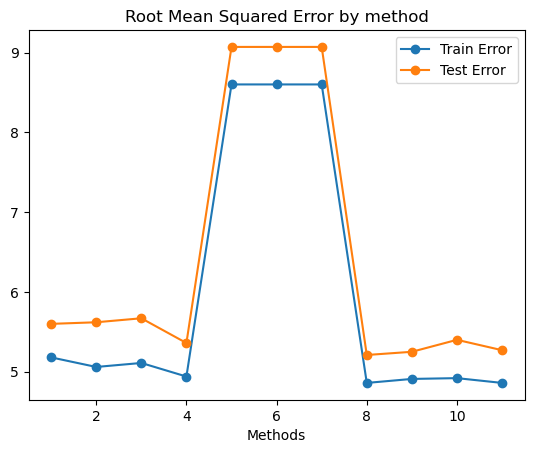

In [13]:
plt.plot(list(range(1,len(train_errors)+1)), train_errors, marker="o")
plt.plot(list(range(1,len(test_errors)+1)), test_errors, marker="o")
plt.legend(["Train Error", "Test Error"])
plt.title("Root Mean Squared Error by method")
plt.xlabel("Methods")

## LSTM

In [ ]:
cols = ["StationEnd", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Count4week", "Temp", "ATemp", "Humidity", "Hour", "WeatherSituation"]

training_data_met8 = training_data[[col for col in training_data.columns if col in cols]]
testing_data_met8 = testing_data[[col for col in testing_data.columns if col in cols]]

trainX = training_data_met8.drop(columns=["Count"])
trainY = training_data_met8["Count"]

testX = testing_data_met8.drop(columns=["Count"])
testY = testing_data_met8["Count"]

trainX = np.reshape(trainX.values, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX.values, (testX.shape[0], 1, testX.shape[1]))

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,testing_data_met8.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam')
model_met1.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(pd.concat([training_data_met8, testing_data_met8]))

# make predictions
trainPredict = model_met1.predict(trainX)
testPredict = model_met1.predict(testX)

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[:], trainPredict[:]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[:], testPredict[:]))
print('Test Score: %.2f RMSE' % (testScore))